In [1]:
import dgl
from Datasets.NodeClassification.Citeseer import Citeseer
from GraphSummarizers.Coarsener.HeteroCoarsener import HeteroCoarsener
import torch
import numpy as np

/home/robin/thesis/convolution-matching/.venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = Citeseer() 
original_graph = dataset.load_graph()


  NumNodes: 3327
  NumEdges: 9228
  NumFeats: 3703
  NumClasses: 6
  NumTrainingSamples: 120
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


In [3]:

coarsener = HeteroCoarsener(None,original_graph, 0.1, num_nearest_per_etype=30, num_nearest_neighbors=30,pairs_per_level=10, is_eval_metrics=True)
coarsener.init_step()
isNewMerges = True
for i in range(1000):
    if not isNewMerges:
        break
    print("--------- step: " , i , "---------" )
    isNewMerges = coarsener.iteration_step()
    

/home/robin/thesis/convolution-matching/GraphSummarizers/Coarsener/HeteroCoarsener.py:119: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  deg_out = torch.tensor(self.node_degrees[etype]['out'], device=self.device) + 1.0
/home/robin/thesis/convolution-matching/GraphSummarizers/Coarsener/HeteroCoarsener.py:120: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  deg_in  = torch.tensor(self.node_degrees[etype]['in'], device=self.device)  + 1.0


_create_h_spatial_rgcn 0.07119131088256836
_init_costs 0.2628905773162842
_get_union 0.7470095157623291
_costs_of_merges 1.9836182594299316
_init_merge_graph 0.020207643508911133
_find_lowest_cost_edges 0.002329587936401367
--------- step:  0 ---------
_merge_nodes 0.6252224445343018
_update_merge_graph 0.05913519859313965
_find_lowest_cost_edges 0.0012845993041992188
--------- step:  1 ---------


/home/robin/thesis/convolution-matching/GraphSummarizers/Coarsener/HeteroCoarsener.py:791: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  node1s = torch.tensor(node1s, dtype=torch.long)
/home/robin/thesis/convolution-matching/GraphSummarizers/Coarsener/HeteroCoarsener.py:792: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  node2s = torch.tensor(node2s, dtype=torch.long)


KeyboardInterrupt: 

In [ ]:
coarsend_graph = coarsener.get_coarsend_graph()
dgl.save_graphs("citeer_graph.bin", [coarsend_graph])
mapping = coarsener.get_mapping("paper")
labels = coarsener._get_labels(mapping, "paper")
        
coarsend_graph.nodes["paper"].data["label"] = torch.tensor([labels[i] for i in range(len(labels))], device=coarsend_graph.device)
print("ratio", coarsend_graph.num_nodes()/ original_graph.num_nodes() ) 


ratio 0.981965734896303


In [28]:
print(coarsener.feat_scores["paper"][10])
print(coarsener.edge_scores["cites"][10])

tensor([ 0.9345, -0.1888,  0.7730,  ...,  0.6888,  1.1061,  1.0931],
       device='cuda:0')
tensor([-0.3994, -0.0157, -0.5860,  ...,  2.4124,  1.6132,  1.5399],
       device='cuda:0')


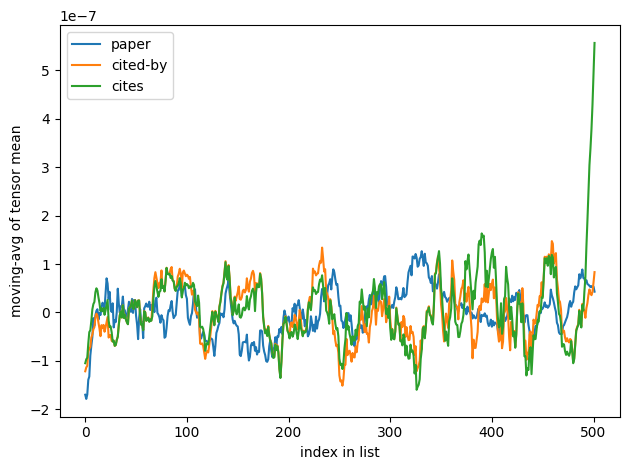

In [19]:
import numpy as np
import matplotlib.pyplot as plt
comnbined = coarsener.feat_scores | coarsener.edge_scores
def moving_average(v, window=5):
    """Simple centered moving average; works on a Python list."""
    if window < 2 or window > len(v):
        return v                      # nothing to smooth
    pad = window // 2
    # pad the ends so the result stays the same length
    v_padded = np.pad(v, (pad, pad), mode="edge")
    kernel = np.ones(window) / window
    return np.convolve(v_padded, kernel, mode="valid")

for key, tensors in comnbined.items():
    raw = [t.mean().item() if hasattr(t, "mean") else float(np.mean(t))
           for t in tensors]
    smooth = moving_average(raw, window=20)   # tweak window as you like
    plt.plot(range(len(smooth)), smooth, label=key)

plt.xlabel("index in list")
plt.ylabel("moving-avg of tensor mean")
plt.legend()
plt.tight_layout()
plt.show()


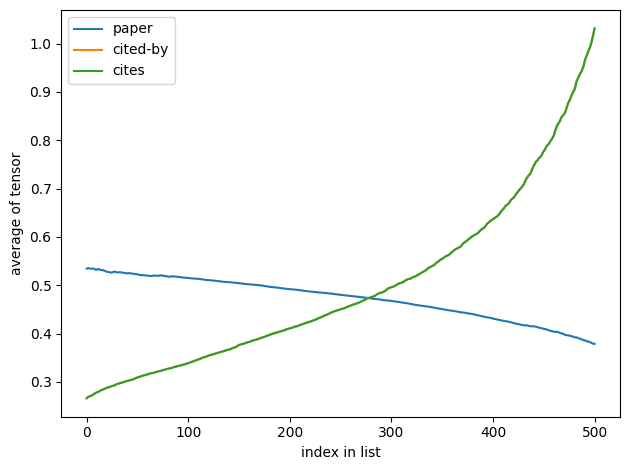

In [21]:
import matplotlib.pyplot as plt   # no explicit color/style settings
# dict_of_lists = {"run-1": [...], "run-2": [...], ...}
comnbined = coarsener.feat_distances | coarsener.edge_distances


for key, tensors in comnbined.items():
    # Reduce each tensor/array to a single scalar (mean here; pick whichever reduction you need)
    y_vals = [t.mean().item() if hasattr(t, "mean") else t.mean() for t in tensors]
    x_vals = range(len(y_vals))          # 0, 1, 2, …
    plt.plot(x_vals, y_vals, label=key)  # one line per key

plt.xlabel("index in list")
plt.ylabel("average of tensor")
plt.legend()
plt.tight_layout()
plt.show()


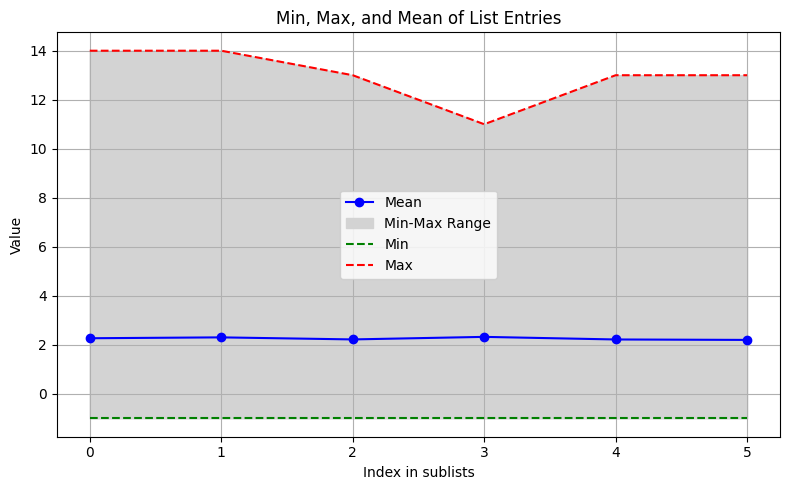

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Example data
data = coarsener.evaluations_distances

# Convert to NumPy array for easier manipulation
arr = np.array(data)

# Compute statistics across rows (axis=0)
mins = arr.min(axis=0)
maxs = arr.max(axis=0)
means = arr.mean(axis=0)

# X-axis positions (index of each element in sublists)
x = np.arange(arr.shape[1])

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(x, means, label='Mean', color='blue', marker='o')
plt.fill_between(x, mins, maxs, color='lightgray', label='Min-Max Range')
plt.plot(x, mins, label='Min', linestyle='--', color='green')
plt.plot(x, maxs, label='Max', linestyle='--', color='red')

plt.xlabel('Index in sublists')
plt.ylabel('Value')
plt.title('Min, Max, and Mean of List Entries')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


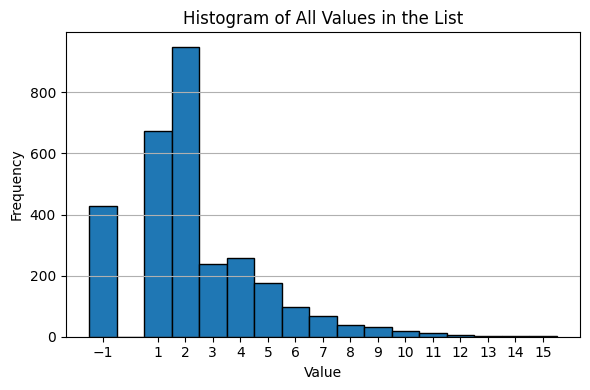

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Example data
data = coarsener.evaluations_distances

# Flatten the list of lists into a 1D list
flattened = [item for sublist in data for item in sublist]

# Optional: Convert to NumPy array for better performance
flattened_array = np.array(flattened)

# Plot histogram
plt.figure(figsize=(6, 4))
plt.hist(flattened_array, bins=np.arange(flattened_array.min(), flattened_array.max() + 2) - 0.5, edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of All Values in the List')
plt.grid(axis='y')
plt.xticks(np.unique(flattened_array))
plt.tight_layout()
plt.show()
